In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from sklearn.cluster import KMeans
import os

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mnist = pd.read_csv('/content/drive/My Drive/Dataset/mnist_train.csv')

In [ ]:
with open("new_index", "rb") as fp:
    correct_indexes = pickle.load(fp)

In [ ]:
print(len(correct_indexes))

12638


In [ ]:
np.random.seed(1)
mnist_correct = pd.DataFrame(columns=mnist.columns, dtype='int64')
for i in correct_indexes:
    mnist_correct = pd.concat([mnist_correct, mnist.iloc[i:i+1]], ignore_index=True)
X = mnist_correct.drop(['label'], axis=1)
y = mnist_correct.label
print(X.shape)

(12638, 784)


In [ ]:
features = X
label = y

In [ ]:
#Plot mnist image
def plot_mnist(img, label=''):
    plt.imshow(img.reshape((28,28)), cmap='gray')
    plt.title(str(label))
    plt.xticks([])
    plt.yticks([])

#Plot mnist in coordinate form
def plot_coord(coord, marker='o', lim=(-1,29)):
    plt.scatter(coord[:,0], coord[:,1], marker=marker)
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xticks([])
    plt.yticks([])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sympy.utilities.iterables import multiset_permutations

perm = np.array(list(multiset_permutations(range(8))))

thld = np.array([70,110,100,110,50,80,100,60,100,70])
#                0   1   2   3  4  5   6  7   8  9

def img2coord(img, scale = 28, pixval_min=0):
    r, c = np.where(img.reshape((28,28))>pixval_min)
    x_coor, y_coor = (c.astype('int64'), (28-r).astype('int64'))
    xycoors = np.concatenate((x_coor.reshape(-1,1), y_coor.reshape(-1,1)), axis=1)
    return xycoors

def mnist2clusters(img, pixval_min=0, scale=28):
    xycoors = img2coord(img, scale=scale, pixval_min=pixval_min)
    kmeans = KMeans(n_clusters=8)
    kmeans.fit(xycoors)
    return kmeans, xycoors

def plot_clusters(kmeans, xycoors, marker='o', lim=(-1,29)):
    pred = kmeans.predict(xycoors)
    plt.scatter(xycoors[:,0], xycoors[:,1], c=pred, cmap='Dark2', marker=marker)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*',color='k')
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xticks([])
    plt.yticks([])

def calculateCentroid():
    if os.path.isfile("centroids.npy"):
        centroids = np.load("centroids.npy")
        return centroids
    average_mnist = mnist.groupby('label').mean().astype('int64').values
    centroids=np.zeros((10,8,2))
    r, c = 2, 5
    plt.figure(figsize=(15,6))
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        img= average_mnist[i]
        img[img<thld[i]] = 0
        plot_mnist(img)
    plt.show()
    plt.figure(figsize=(15,6))
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        img= average_mnist[i]
        img[img<thld[i]] = 0
        kmt,xy = mnist2clusters(img, pixval_min=thld[i])
        plot_clusters(kmt,xy)
        centroids[i] = kmt.cluster_centers_
    np.save("centroids.npy", centroids)
    return centroids

order=np.array([[4,1,6,3,2,5,7,0],#0
                [7,2,5,0,3,4,1,6],#1
                [5,1,6,3,2,4,7,0],#2
                [2,5,0,6,7,3,4,1],#3
                [7,5,0,2,1,3,4,6],#4
                [4,0,5,6,3,1,2,7],#5
                [7,1,3,0,4,2,5,6],#6
                [2,7,1,5,4,6,0,3],#7
                [4,0,7,1,5,3,6,2],#8
                [4,3,6,2,5,0,1,7]])#9


def plot_mnist(img, label=''):
    plt.imshow(img.reshape((28,28)), cmap='gray')
    plt.title(str(label))
    plt.xticks([])
    plt.yticks([])

def plot_coord(coord, marker='o', lim=(-1,29)):
    plt.scatter(coord[:,0], coord[:,1], marker=marker)
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xticks([])
    plt.yticks([])

def mse(c1, c2):
    return np.mean((c1-c2)**2)

def mse_centroids(centroid_indx, tmplt, centroids):
    return mse(tmplt, centroids[perm[centroid_indx]])

def minimize(tmplt, centroids):
    mse_val = [mse_centroids(i, tmplt, centroids) for i in range(len(perm))]
    return centroids[perm[np.argmin(mse_val)]], np.min(mse_val)

def feature_extractor(img, label, centroids, return_clusters=False):
    tmplt = centroids[label][order[label]]
    km, xy = mnist2clusters(img, pixval_min=thld[label])
    points8, _ = minimize(tmplt, km.cluster_centers_.astype('float64'))
    if return_clusters:
        return points8, km, xy
    return points8

def form_clusters(points8, xy):
    clusters = [[] for i in range(8)]
    for i in range(len(xy)):
        mse_val = [mse(xy[i], points8[j]) for j in range(len(points8))]
        ind = np.argmin(mse_val)
        clusters[ind].append(xy[i])
    for i in range(1,len(clusters)):
        clusters[i].extend(clusters[i-1])
    clusters = np.array(clusters,dtype="object")
    return clusters

def plot_embeddings(coord, word2Ind, words, marker = '--o', c = 'tab:blue', lim = (-1,29)):
    """ 
        Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    word2Ind = list(word2Ind)
    for word in words:
        x, y = coord[word2Ind[word]]
        plt.text(x+.03, y+.03, word, fontsize=11)

def plot_exfeatures(coord, i, marker='--o', c='tab:blue',lim=(-1,29)):
    n = [0,1,2,3,4,5,6,7]
    l = {key: i for i, key in enumerate(n)}
    tmplt = centroids[i][order[i]]
    plot_embeddings(tmplt,l,n)
    plt.plot(coord[:,0],coord[:,1], marker, color=c)
    plt.scatter(coord[0,0],coord[0,1], marker='s', color=c)
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xticks([])
    plt.yticks([])

def get_boundary(coord):
    xmin = coord[:,0].min()
    xmax = coord[:,0].max()
    ymin = coord[:,1].min()
    ymax = coord[:,1].max()
    return xmin,ymin,xmax,ymax

def scale_centroid(coord):
    xmin,ymin,xmax,ymax = get_boundary(coord)
    x_o = (xmax + xmin)/2
    y_o = (ymax + ymin)/2
    coord = coord - [x_o,y_o]
    sc = 28/100
    coord *= sc
    coord += 14
    return coord.astype('int64')

def scale(coord):
    xmin,ymin,xmax,ymax = get_boundary(coord)
    x_o = (xmax + xmin)/2
    y_o = (ymax + ymin)/2
    coord = coord - [x_o,y_o]
    sc = 28/max(xmax-xmin, ymax-ymin)
    coord *= sc
    coord += 14
    return coord.astype('int64')

def coord2img(xy, feat, ind):
    zero_data = np.zeros(shape=(1,feat.shape[1]))
    d = pd.DataFrame(zero_data, columns=feat.columns)
    d = np.array(d.values).reshape((28,28))
    e = pd.DataFrame(zero_data, columns=feat.columns)
    e = np.array(e.values).reshape((28,28))
    img = np.array(features.iloc[ind].values).reshape((28,28))
    for a,b in xy:
        d[b][a] = img[28-b][a]
        e[28-b][a] = img[28-b][a]
    return d,e

def plot_seq(kms, clusters, ind, marker='o', lim=(-1,29)):
    plt.figure(figsize=(12,6))
    images = np.empty((0,28,28), int)
    for i in range(len(clusters)):
        plt.subplot(1,8,i+1)
        xy = np.array(clusters[i])
        j,k= coord2img(xy, features, ind)
        images = np.append(images, np.array([k]), axis=0)
        plot_mnist(j)
        plt.xlim(lim)
        plt.ylim(lim)
        plt.xticks([])
        plt.yticks([])
    return images
def generate_dataset(kms, clusters, ind):
    images = np.empty((0,28,28), int)
    for i in range(len(clusters)):
        xy = np.array(clusters[i])
        j,k= coord2img(xy, features, ind)
        images = np.append(images, np.array([k]), axis=0)
    return images

In [ ]:
centroids = calculateCentroid()

<Figure size 1080x360 with 0 Axes>

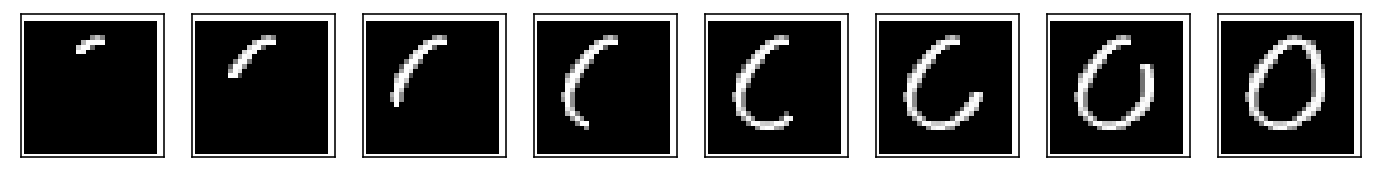

In [ ]:
np.random.seed(0)
indx=301
plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plot_mnist(features.iloc[indx].values)
pts, kms, xys = feature_extractor(features.iloc[indx].values, label[indx], centroids, return_clusters=True)
clusters = form_clusters(pts,xys)
# plt.subplot(1,3,2)
# plot_clusters(kms, xys)
# plt.subplot(1,3,3)
# plot_exfeatures(pts, y[indx])
images = plot_seq(kms, clusters, indx)
plt.show()

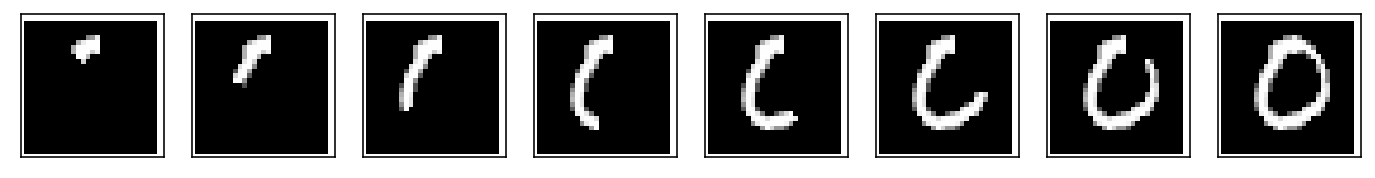

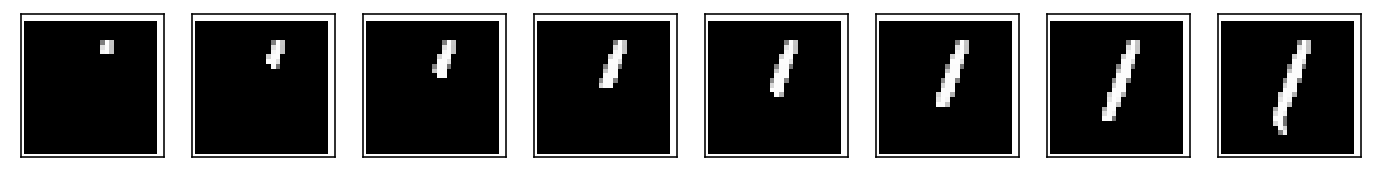

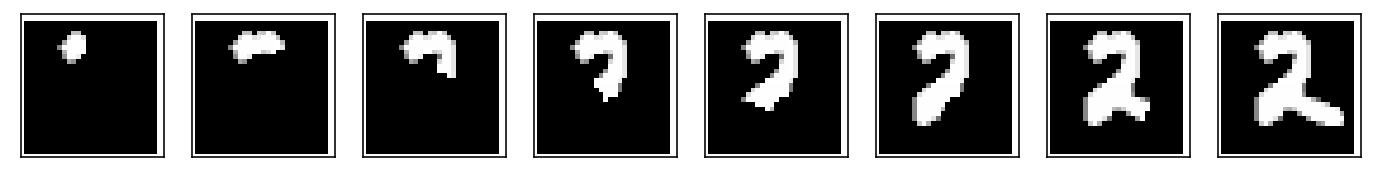

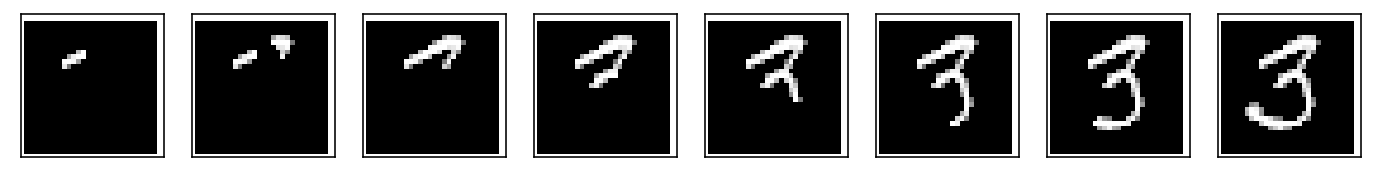

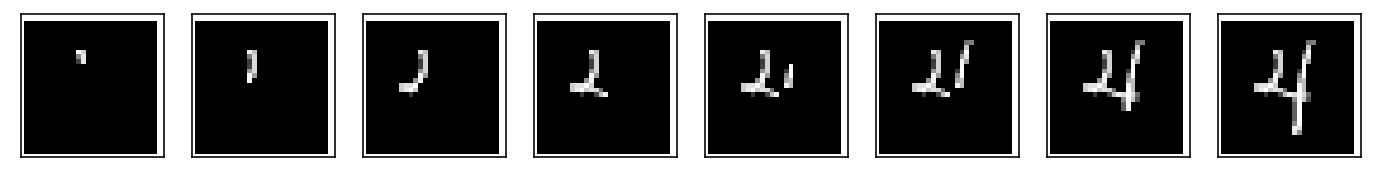

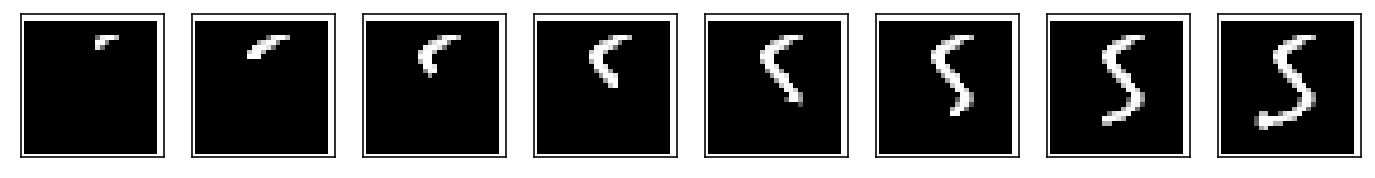

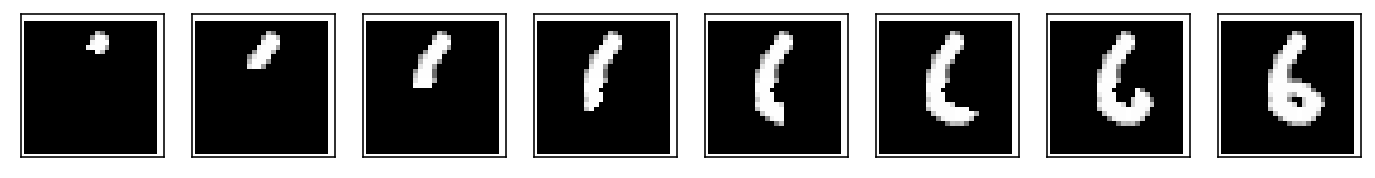

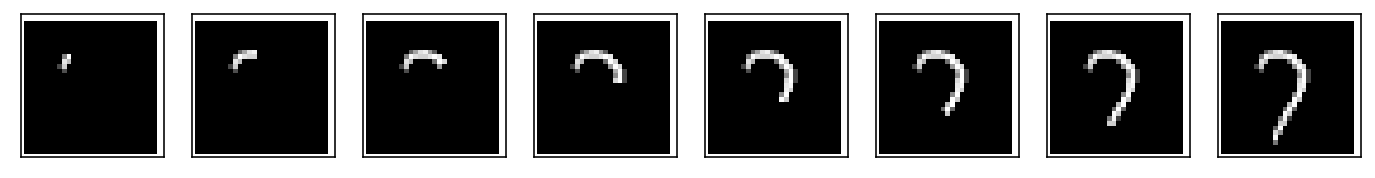

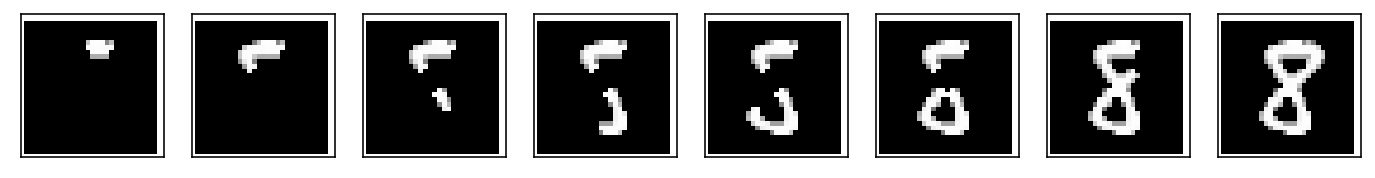

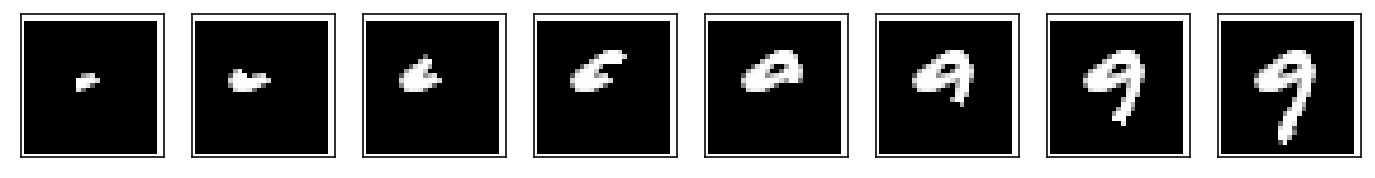

In [ ]:
import random
for i in range(10):
    if(i==6):
        indx = (label[label==i].index)[1]
    else:
        indx = (label[label==i].index)[16]
    pts, kms, xys = feature_extractor(features.iloc[indx].values, label[indx], centroids, return_clusters=True)
    clusters = form_clusters(pts,xys)
    images = plot_seq(kms, clusters, indx)
    plt.show()

In [ ]:
#Generate video seq

import numpy as np
import cv2
import os
 
width = 28
height = 28
channel = 1
 
fps = 2
sec = 4

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # FourCC is a 4-byte code used to specify the video codec.
# A video codec is software or hardware that compresses and decompresses digital video. 
# In the context of video compression, codec is a portmanteau of encoder and decoder, 
# while a device that only compresses is typically called an encoder, and one that only 
# decompresses is a decoder. Source - Wikipedia
 
#Syntax: cv2.VideoWriter( filename, fourcc, fps, frameSize )


for i in range(len(features)):
    video = cv2.VideoWriter("test"+str(i)+".mp4", fourcc, float(fps), (width, height),0)
    pts, kms, xys = feature_extractor(features.iloc[i].values, label[i], centroids, return_clusters=True)
    images = plot_seq(kms, clusters, i)
    for frame_count in range(fps*sec):
        img = np.array(images[frame_count], 'uint8')
        video.write(img)
    video.release()